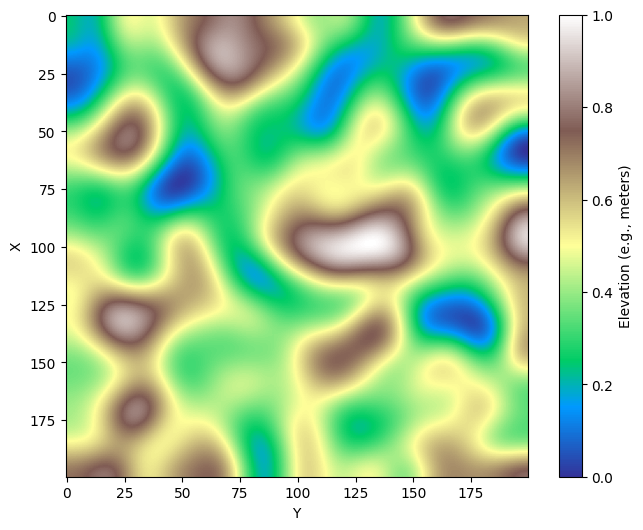

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random

# =============================
# 1. 数据生成与处理
# =============================

# 设置随机种子，保证可重复
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# 定义图像尺寸和序列长度
IMG_H, IMG_W = 200, 200
SEQ_LEN = 20

# 生成一张固定的高程图（灰度值归一化到 [0,1]）
# 这里使用高斯滤波的随机噪声模拟地形
base_map = np.random.rand(IMG_H, IMG_W)
from scipy.ndimage import gaussian_filter
elevation_map = gaussian_filter(base_map, sigma=10)  # 平滑处理
elevation_map = elevation_map.astype(np.float32)
# 将图像归一化（可选步骤，这里数值本身已在 [0,1] 范围内）
elevation_map = (elevation_map - elevation_map.min()) / (elevation_map.max() - elevation_map.min())


# 可视化高程图
plt.figure(figsize=(8, 6))
plt.imshow(elevation_map, cmap='terrain')
plt.colorbar(label='Elevation (e.g., meters)')
plt.xlabel("Y")
plt.ylabel("X")
plt.show()


In [3]:
def extract_trajectory_patch(elevation_map: np.ndarray, length, x, y, heading) -> np.ndarray:
    """通过航向确定轨迹"""
    rad = np.deg2rad(heading)
    dx = np.cos(rad)
    dy = -np.sin(rad)

    profile = []
    x_pos_list, y_pos_list = [], []
    for i in range(length):
        xi = int(round(x + i * dx))
        yi = int(round(y + i * dy))
        if 0 <= xi < elevation_map.shape[0] and 0 <= yi < elevation_map.shape[1]:
            profile.append(elevation_map[xi, yi])
            x_pos_list.append(xi)
            y_pos_list.append(yi)
        else:
            profile.append(np.nan)
            x_pos_list.append(np.nan)
            y_pos_list.append(np.nan)
    
    # 如果越界则直接弃用该样本
    if np.any(np.isnan(profile)):
        return None, None
    
    return (np.array(x_pos_list), np.array(y_pos_list)), np.array(profile) 

In [4]:
# 构建训练集
NUM_TRAIN = 5000
NUM_TEST = 200

train_seqs = []
train_coords = []
for _ in range(NUM_TRAIN):
    x = random.random()*IMG_W
    y = random.random()*IMG_H
    heading = random.random()*0

    sample = extract_trajectory_patch(elevation_map, length=20, x=x, y=y, heading=heading)
    if sample[1] is None:
        continue
    (xs, ys), heights = sample
    train_seqs.append(heights.astype(np.float32))
    # 保存真实坐标并归一化到 [0,1]
    xs_norm = xs / IMG_W
    ys_norm = ys / IMG_H
    coords_norm = np.stack([xs_norm, ys_norm], axis=1)  # shape (N,2)
    train_coords.append(coords_norm.astype(np.float32))


In [5]:
test_seqs = []
test_coords = []
for _ in range(NUM_TEST):
    x = random.random()*IMG_W
    y = random.random()*IMG_H
    heading = random.random()*0

    sample = extract_trajectory_patch(elevation_map, length=20, x=x, y=y, heading=heading)
    if sample[1] is None:
        continue
    (xs, ys), heights = sample
    test_seqs.append(heights.astype(np.float32))
    xs_norm = xs / IMG_W
    ys_norm = ys / IMG_H
    coords_norm = np.stack([xs_norm, ys_norm], axis=1)
    test_coords.append(coords_norm.astype(np.float32))

train_seqs = np.array(train_seqs)   # shape (NUM_TRAIN, N)
train_coords = np.array(train_coords)  # shape (NUM_TRAIN, N, 2)
test_seqs = np.array(test_seqs)
test_coords = np.array(test_coords)


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter


# 生成 CoordConv 输入
xs = np.linspace(0,1,IMG_W); ys = np.linspace(0,1,IMG_H)
grid_x, grid_y = np.meshgrid(xs, ys)
coord_map = np.stack([elevation_map, grid_x, grid_y],0).astype(np.float32)
coord_map_tensor = torch.tensor(coord_map).unsqueeze(0)  # (1,3,H,W)

train_ds = TensorDataset(
    torch.tensor(train_seqs).unsqueeze(1),
    torch.tensor(train_coords)
)
test_ds = TensorDataset(
    torch.tensor(test_seqs).unsqueeze(1),
    torch.tensor(test_coords)
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [7]:
# =============================
# 2. 模型：CoordConv + Attention
# =============================
class AttentionMatcher(nn.Module):
    def __init__(self, H, W, N, d_model=64):
        super().__init__()
        self.N = N
        # CoordConv backbone
        self.cnn = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,d_model,3,padding=1), nn.ReLU()
        )
        # Sequence encoder: 保留时序维度
        self.seq_net = nn.Sequential(
            nn.Conv1d(1,16,3,padding=1), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(16,d_model,3,padding=1), nn.ReLU(),
            nn.Upsample(size=N, mode='linear', align_corners=False)  # 恢复到长度 N
        )
        # 下采样特征图尺寸
        H4, W4 = H//4, W//4
        # 生成特征图对应的归一化坐标 (HW,2)
        ys = torch.linspace(0,1,H4); xs = torch.linspace(0,1,W4)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        self.register_buffer('spatial_coords', torch.stack([grid_x, grid_y],-1).view(-1,2))  # (HW,2)

    def forward(self, img, seq):
        B = seq.size(0)
        # 图像特征 (B,d,H4,W4)
        feat = self.cnn(img)
        B, D, H4, W4 = feat.shape
        # Flatten 空间 -> (B, HW, D)
        kv = feat.view(B, D, -1).permute(0,2,1)
        # 序列特征 -> (B, D, N) -> 转置为 (B, N, D)
        s = self.seq_net(seq)  # (B,d,N)
        q = s.permute(0,2,1)    # (B,N,d)
        # Attention
        scores = torch.matmul(q, kv.transpose(1,2)) / np.sqrt(D)  # (B,N,HW)
        attn   = torch.softmax(scores, dim=-1)
        # Weighted sum得到坐标 (B,N,2)
        coords = torch.matmul(attn, self.spatial_coords)  
        return coords

# 实例化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionMatcher(IMG_H, IMG_W, N=20).to(device)
opt   = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [8]:
# =============================
# 3. 训练
# =============================
for epoch in range(50):
    model.train()
    total=0
    for seqs, coords in train_loader:
        B=seqs.size(0)
        imgs = coord_map_tensor.expand(B,-1,-1,-1).to(device)
        seqs, coords = seqs.to(device), coords.to(device)
        out = model(imgs, seqs)
        loss=criterion(out, coords)
        opt.zero_grad(); loss.backward(); opt.step()
        total+=loss.item()
    print(f"Epoch {epoch+1}, loss={total/len(train_loader):.5f}")

Epoch 1, loss=0.07444
Epoch 2, loss=0.07139
Epoch 3, loss=0.07147
Epoch 4, loss=0.07108
Epoch 5, loss=0.07104
Epoch 6, loss=0.07096
Epoch 7, loss=0.07093
Epoch 8, loss=0.07069
Epoch 9, loss=0.07052
Epoch 10, loss=0.07041
Epoch 11, loss=0.07038
Epoch 12, loss=0.07024
Epoch 13, loss=0.07015
Epoch 14, loss=0.07006
Epoch 15, loss=0.07005
Epoch 16, loss=0.07020
Epoch 17, loss=0.06995
Epoch 18, loss=0.06979
Epoch 19, loss=0.06985
Epoch 20, loss=0.06960
Epoch 21, loss=0.06939
Epoch 22, loss=0.06947
Epoch 23, loss=0.06933
Epoch 24, loss=0.06928
Epoch 25, loss=0.06909
Epoch 26, loss=0.06919
Epoch 27, loss=0.06906
Epoch 28, loss=0.06893
Epoch 29, loss=0.06886
Epoch 30, loss=0.06889
Epoch 31, loss=0.06879
Epoch 32, loss=0.06868
Epoch 33, loss=0.06867
Epoch 34, loss=0.06844
Epoch 35, loss=0.06857
Epoch 36, loss=0.06844
Epoch 37, loss=0.06831
Epoch 38, loss=0.06829
Epoch 39, loss=0.06847
Epoch 40, loss=0.06840
Epoch 41, loss=0.06821
Epoch 42, loss=0.06802
Epoch 43, loss=0.06819
Epoch 44, loss=0.068

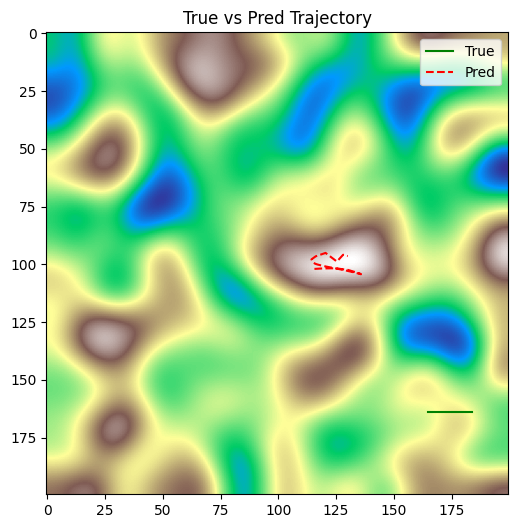

In [9]:
# =============================
# 4. 可视化
# =============================
model.eval()
with torch.no_grad():
    seqs, coords = next(iter(test_loader))
    B=seqs.size(0)
    imgs = coord_map_tensor.expand(B,-1,-1,-1).to(device)
    pred = model(imgs, seqs.to(device)).cpu().numpy()
    true=coords.numpy()

idx = random.randrange(B)
plt.figure(figsize=(6,6))
plt.imshow(elevation_map, cmap='terrain')
# 真实 vs 预测，乘回像素坐标
tx = true[idx,:,0]*IMG_W; ty=true[idx,:,1]*IMG_H
px = pred[idx,:,0]*IMG_W; py=pred[idx,:,1]*IMG_H
plt.plot(tx, ty, 'g-', label='True')
plt.plot(px, py, 'r--', label='Pred')
plt.legend(); plt.title("True vs Pred Trajectory"); plt.show()